# Paul Lussier 
# Created: 09/17/21 
This notebok is a copy of the one I created to learn and understand what Abhi Pote Shrestha and Chen-Hsiang Yu did in their research. In this notebook I will try and apply a convolutional neural net using keras and tensorflow to get a better predictor of heart rhythm


In [1]:
pip install wfdb

     |████████████████████████████████| 137 kB 10.0 MB/s 
     |████████████████████████████████| 11.2 MB 27.5 MB/s 
     |████████████████████████████████| 884 kB 43.5 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [2]:
# pip uninstall matplotlib


In [3]:
pip install matplotlib==3.1.3

     |████████████████████████████████| 13.1 MB 14.9 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.1
    Uninstalling matplotlib-3.5.1:
      Successfully uninstalled matplotlib-3.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
wfdb 3.4.1 requires matplotlib>=3.3.4, but you have matplotlib 3.1.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [1]:
import wfdb 
import os
import struct
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import load_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error



In [2]:
print(tf.__version__)

2.7.0


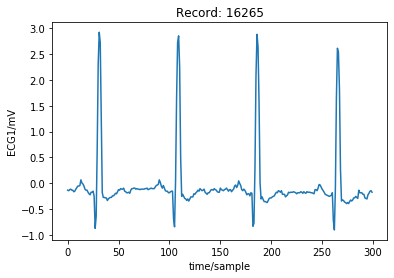

In [3]:
test_segments = []
test_records = ["16265", "16272", "16273", "16420", "16483", 
               "16539", "16773", "16786", "16795", "17052", 
               "17453", "18177", "18184", "19088", "19090", 
               "19093", "19140", "19830"]

testSig = wfdb.rdrecord("16265",
                        channels=[0],
                        sampfrom=100,
                        sampto=400,
                        pn_dir='nsrdb/')
wfdb.plot.plot_wfdb(testSig)

In [5]:
# segmentData is a method to get the ECG data from PhysioNet into the program for analysis and model
# building - consolidated versionof work done by Sherasth et. al. durign research with Prof. Jones Yu of Wentworth Institute of Technology
# Returns: List of numpy arrays with a classification number as last element of each
# Parameters: 
#   recordList: list of records as shown in PhysioNet data page stored as strings
#   recordPath: path to the PhysioNet page ie. 'nsrdb/'
#   numSamples: number of samples being read by wfdb.rdrecord()
#   classification: the number assigned to the type of heartrate being read NSR-1 CHF-2 AF-3
#   segmentSize: number of data points in each segment
def segmentData(recordList, recordPath, numSamples, classification, segmentSize):

  segments_out = [] # List of segments to be output to the variable caling the function

  print("--Start of segmentation for type", classification,"--")
  print("Len recordList:", len(recordList))

  for record in recordList: # start of loop that runs length of passed in list of records
    # curr is a temp variable holding the record being added to the final list
    curr = wfdb.rdrecord(record, channels=[0], sampto=numSamples, pn_dir=recordPath) 
    samples = curr.__dict__['p_signal']
    n=len(samples)

    # print("Record:", record, "Length:", n, "Segments:", n//segmentSize)
 
    start = 0
    while start < n: # Start while loop
      if (n-start < segmentSize):
        # if the length - the displacement of the start is less than 5000 then the loop
        # has beed through all of the segments and ends
        break
      else:
        segment = samples[start:start+segmentSize] # creates a numpy array and fills it with the next [segmentSize] values
        segment = np.append(segment,[classification]) # adds a number to the end so the type of rhythm can be ID'd
        segments_out.append(segment) # adds the finished segment to the output list with its calssification tacked on
        start += segmentSize # iterates start to the next segment
    # End while loop
  # End for loop
  print("Record:", record, "Length:", n, "Segments:", n//segmentSize)
  print("--End of segmentation for type", classification,"--")
  return segments_out


In [25]:

nsr_records = ["16265", "16272", "16273", "16420", "16483",
               "16539", "16773", "16786", "16795", "17052", 
               "17453", "18177", "18184", "19088", "19090", 
               "19093", "19140", "19830"]


# chf_records = ["chf01", "chf02", "chf03", "chf04", "chf05",
               # "chf06", "chf07", "chf08", "chf09", "chf10",
               # "chf11", "chf12", "chf13", "chf14", "chf15"]

# chf records with bad data removed
chf_records = ["chf01", "chf03", "chf04", "chf05", "chf07",
               "chf08", "chf09", "chf10", "chf11", "chf12",
               "chf13", "chf14", "chf15"]

# af_records = ["04015", "04043", "04048", "04126", "04746", 
              # "04908", "04936", "05091", "05121", "05261", 
              # "06426", "06453", "06995", "07162", "07859", 
              # "07879", "07910", "08215", "08219", "08378", 
              # "08405", "08434", "08455"]

# af records with bad data removed
af_records = ["04015", "04043", "04048", "04126", "04746",
              "04908", "05121", "05261", "06426", "06453",
              "06995", "07162", "07859", "07879", "07910",
              "08215", "08219", "08378", "08405", "08434",
              "08455"]

nsr_path = 'nsrdb/'
chf_path = 'chfdb/'
af_path = 'afdb/'

nsr_numSamples = 700000
chf_numSamples = 1000000
af_numSamples = 650000

segmentSize = 5000

nsr_segments = np.array(segmentData(nsr_records, nsr_path, nsr_numSamples,1,segmentSize))
chf_segments = np.array(segmentData(chf_records,chf_path,chf_numSamples,2,segmentSize))
af_segments = np.array(segmentData(af_records,af_path,af_numSamples,3,segmentSize))

--Start of segmentation for type 1 --
Len recordList: 18
Record: 19830 Length: 700000 Segments: 140
--End of segmentation for type 1 --
--Start of segmentation for type 2 --
Len recordList: 13
Record: chf15 Length: 1000000 Segments: 200
--End of segmentation for type 2 --
--Start of segmentation for type 3 --
Len recordList: 21
Record: 08455 Length: 650000 Segments: 130
--End of segmentation for type 3 --


In [26]:
# Separating labels from segments for all three rhythm types
nsrSegNp = np.array(nsr_segments)
chfSegNp = np.array(chf_segments)
afSegNp = np.array(af_segments)

nsr_labels = nsrSegNp[0:,segmentSize]
nsr_labels = nsr_labels.reshape(nsr_labels.shape[0],1)
nsrSegNp = np.delete(nsrSegNp,segmentSize,1)

chf_labels = chfSegNp[0:,segmentSize]
chf_labels = chf_labels.reshape(chf_labels.shape[0],1)
chfSegNp = np.delete(chfSegNp,segmentSize,1)

af_labels = afSegNp[0:,segmentSize]
af_labels = af_labels.reshape(af_labels.shape[0],1)
afSegNp = np.delete(afSegNp,segmentSize,1)
print("nsrSegNp shape:",nsrSegNp.shape)
print("chfSegNp shape:",chfSegNp.shape)
print("afSegNp shape:",afSegNp.shape)
print("nsr labels shape:",nsr_labels.shape)
print("chf labels shape:",chf_labels.shape)
print("af labels shape:",af_labels.shape)
# print(nsr_labels[0:10])
# print(chf_labels[0:10])
# print(af_labels[0:10])

nsrSegNp shape: (2520, 5000)
chfSegNp shape: (2600, 5000)
afSegNp shape: (2730, 5000)
nsr labels shape: (2520, 1)
chf labels shape: (2600, 1)
af labels shape: (2730, 1)


In [27]:
# Resampling nsr data from 128 Hz to 250 Hz using np.interp
x250 = np.arange(0,20,0.004)
x128 = np.arange(0,39.06,0.0078125)

nsrResamp = np.zeros_like(nsrSegNp)

for i in range(0,len(nsrSegNp)):
  nsrResamp[i] = np.interp(x250,x128,nsrSegNp[i])
print("nsrSegNp shape:",nsrSegNp.shape)
print("nsrResamp shape:",nsrResamp.shape)

# nsrSegNp = np.append(nsrResamp,nsr_labels,axis = 1)

# print(type(nsr_segments))
# print(nsr_segments.shape)

nsrSegNp shape: (2520, 5000)
nsrResamp shape: (2520, 5000)


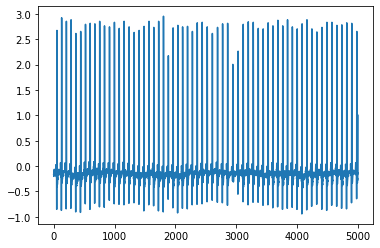

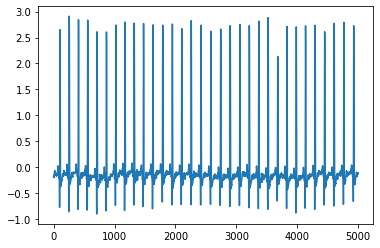

In [31]:
plt.figure(100)
plt.plot(nsr_segments[0])
plt.figure(200)
plt.plot(nsrResamp[0])
plt.savefig('nsrResampExample.png',dpi=128)
# Visual confirmation of resampled data

In [32]:
# setting segments varaibels to the properly sampled arrays with labels removed
nsr_segments = nsrResamp
chf_segments = chfSegNp
af_segments = afSegNp

In [33]:
# Adding back lables to segemts 
nsr_segments = np.append(nsr_segments,nsr_labels,axis = 1)
chf_segments = np.append(chf_segments,chf_labels,axis = 1)
af_segments = np.append(af_segments,af_labels,axis = 1)

In [34]:
print(type(nsr_segments))
# print(nsr_segments)
# print(chfSegNp)
print("Total number of segments for Normal Sinus Rhythm:",len(nsr_segments))
print("Total number of segments for Congestive Heart Failure:",len(chf_segments))
print("Total number of segments for Atrial Fibrillation:",len(af_segments))
print("nsr_segments shape:",nsr_segments.shape)
print("chf_segments shape:",chf_segments.shape)
print("af_segments shape:",af_segments.shape)

<class 'numpy.ndarray'>
Total number of segments for Normal Sinus Rhythm: 2520
Total number of segments for Congestive Heart Failure: 2600
Total number of segments for Atrial Fibrillation: 2730
nsr_segments shape: (2520, 5001)
chf_segments shape: (2600, 5001)
af_segments shape: (2730, 5001)


In [38]:
# nsr_segments = nsr_segments[:2500]
# chf_segments = chf_segments[:2500]
# af_segments = af_segments[:2500]

nsr_segments = nsr_segments[:2500]
chf_segments = chf_segments[:2500]
af_segments = af_segments[:2500]

print("Total number of segments for Normal Sinus Rhythm:",nsr_segments.shape)
print("Total number of segments for Congestive Heart Failure:",chf_segments.shape)
print("Total number of segments for Atrial Fibrillation:",af_segments.shape)



Total number of segments for Normal Sinus Rhythm: (2500, 5001)
Total number of segments for Congestive Heart Failure: (2500, 5001)
Total number of segments for Atrial Fibrillation: (2500, 5001)


In [39]:
# Compile all the segments into a single matrix
full_data = np.concatenate((nsr_segments, chf_segments,af_segments),axis = 0)
print("Number of total segments:",full_data.shape)

Number of total segments: (7500, 5001)


In [40]:
# Split the array into training and testing arrays randomly
train_data, test_data = train_test_split(full_data, test_size=0.3,random_state=42)

<class 'numpy.ndarray'>


In [41]:
train_df = pd.DataFrame(data = train_data,index=np.array(range(len(train_data))),
                        columns=np.array(range(segmentSize+1)))
train_df.rename(columns={segmentSize:'Label'},inplace=True)
train_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,4961,4962,4963,4964,4965,4966,4967,4968,4969,4970,4971,4972,4973,4974,4975,4976,4977,4978,4979,4980,4981,4982,4983,4984,4985,4986,4987,4988,4989,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999,Label
0,-0.125,-0.08000,-0.0750,-0.0800,-0.0850,-0.090,-0.08000,-0.06000,-0.08500,-0.07500,-0.0800,-0.08500,-0.09500,-0.09500,-0.09500,-0.1050,-0.08000,-0.09500,-0.07000,-0.09000,-0.085,-0.090,-0.09000,-0.07500,-0.08000,-0.070,-0.0600,-0.0650,-0.08500,-0.07000,-0.075,-0.060,-0.07000,-0.07500,-0.06500,-0.0400,-0.05000,-0.05500,-0.07000,-0.04500,...,0.0900,0.0900,0.09500,0.09000,0.0850,0.08500,0.09500,0.09000,0.10500,0.0950,0.1150,0.1000,0.10500,0.10500,0.100,0.12000,0.1050,0.1050,0.13000,0.1150,0.12500,0.14500,0.1350,0.1450,0.1400,0.15000,0.15500,0.16000,0.15500,0.1550,0.13500,0.14000,0.13500,0.13000,0.1300,0.13500,0.14000,0.13000,0.13000,3.0
1,-0.265,-0.65500,-0.9500,-1.1000,-1.0700,-0.940,-0.85000,-0.83500,-0.89500,-0.91000,-0.8400,-0.81000,-0.78500,-0.65500,-0.53500,-0.4600,-0.43500,-0.43000,-0.43000,-0.47000,-0.500,-0.525,-0.50000,-0.40000,-0.30000,-0.210,-0.0700,-0.0100,0.02500,0.06000,0.085,0.095,0.10500,0.13500,0.12000,0.1350,0.15000,0.15500,0.16000,0.19500,...,-2.0250,-1.9900,-1.89000,-1.81500,-1.8250,-1.82000,-1.74000,-1.67000,-1.61500,-1.5000,-1.3500,-1.3000,-1.24500,-1.18000,-1.095,-1.04000,-1.0350,-1.0500,-1.03500,-1.0200,-0.94000,-0.79000,-0.5900,-0.4450,-0.3150,-0.27000,-0.23000,-0.19000,-0.17000,-0.1600,-0.15000,-0.13000,-0.13000,-0.10500,-0.1150,-0.06500,-0.04000,-0.02500,0.00000,3.0
2,0.010,0.01500,0.0250,0.0500,0.0400,0.010,0.01500,-0.00500,-0.02000,-0.03500,-0.0500,-0.11500,-0.14000,-0.17500,-0.21500,-0.2350,-0.23500,-0.25500,-0.27500,-0.29000,-0.250,-0.225,-0.25000,-0.25500,-0.25000,-0.250,-0.2550,-0.2550,-0.28000,-0.28000,-0.285,-0.290,-0.32000,-0.40000,-0.49500,-0.5400,-0.51000,-0.50000,-0.37000,-0.12500,...,-0.2550,-0.2550,-0.22000,-0.27500,-0.2550,-0.22500,-0.28500,-0.26500,-0.27500,-0.2550,-0.2600,-0.2550,-0.27000,-0.28000,-0.305,-0.28000,-0.2750,-0.2650,-0.32000,-0.3350,-0.31000,-0.29000,-0.3000,-0.3000,-0.3300,-0.32500,-0.33500,-0.31500,-0.30500,-0.3250,-0.29500,-0.34000,-0.31000,-0.29500,-0.2900,-0.31500,-0.36500,-0.35000,-0.32000,3.0
3,-0.500,-0.52000,-0.5050,-0.4900,-0.4600,-0.460,-0.46000,-0.45000,-0.45500,-0.47500,-0.4700,-0.50000,-0.51500,-0.52000,-0.50500,-0.4550,-0.45000,-0.43500,-0.44000,-0.45000,-0.465,-0.435,-0.41000,-0.40500,-0.38500,-0.405,-0.4150,-0.4250,-0.44000,-0.43000,-0.415,-0.380,-0.40500,-0.43000,-0.41000,-0.4050,-0.40500,-0.39000,-0.40000,-0.43000,...,-0.7750,-0.7650,-0.74500,-0.71500,-0.7050,-0.66500,-0.65500,-0.64500,-0.61500,-0.6300,-0.6100,-0.6150,-0.59000,-0.57500,-0.565,-0.56000,-0.5600,-0.5600,-0.57000,-0.5550,-0.54000,-0.55000,-0.5350,-0.5600,-0.5600,-0.57000,-0.57000,-0.56500,-0.57500,-0.5800,-0.60000,-0.59500,-0.61500,-0.61500,-0.6250,-0.61500,-0.63000,-0.66000,-0.68000,2.0
4,-0.320,-0.32500,-0.3150,-0.3050,-0.3050,-0.320,-0.32000,-0.33000,-0.31500,-0.32000,-0.3050,-0.33000,-0.33500,-0.33000,-0.32000,-0.2900,-0.28500,-0.27000,-0.24500,-0.23500,-0.225,-0.200,-0.21500,-0.21500,-0.21500,-0.255,-0.2750,-0.2750,-0.31000,-0.29500,-0.290,-0.290,-0.30000,-0.28500,-0.31000,-0.3100,-0.32500,-0.31500,-0.32500,-0.32000,...,-0.1200,-0.1550,-0.17000,-0.18000,-0.1800,-0.18000,-0.16000,-0.17000,-0.14500,-0.1750,-0.1950,-0.2200,-0.24000,-0.28500,-0.305,-0.32000,-0.3650,-0.4000,-0.39000,-0.3800,-0.36500,-0.36000,-0.3650,-0.3700,-0.3450,-0.36000,-0.35000,-0.33000,-0.32000,-0.3200,-0.31000,-0.29500,-0.31000,-0.28500,-0.2800,-0.27500,-0.27000,-0.26000,-0.27000,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [42]:
train_features = train_df.drop(['Label'],axis=1).values
train_labels = train_df['Label']
train_labels

0       3.0
1       3.0
2       3.0
3       2.0
4       2.0
       ... 
5245    3.0
5246    3.0
5247    3.0
5248    1.0
5249    3.0
Name: Label, Length: 5250, dtype: float64

In [44]:
test_df = pd.DataFrame(data=test_data,
          index=np.array(range(len(test_data))),
          columns=np.array(range(segmentSize+1)))
test_df.rename(columns={segmentSize:'Label'},inplace=True)
test_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,4961,4962,4963,4964,4965,4966,4967,4968,4969,4970,4971,4972,4973,4974,4975,4976,4977,4978,4979,4980,4981,4982,4983,4984,4985,4986,4987,4988,4989,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999,Label
0,-0.065,-0.05988,-0.05332,-0.01748,0.01548,0.0206,0.02860,0.05420,0.07884,0.09932,0.1210,0.14660,0.17508,0.21092,0.24676,0.2826,0.31844,0.35428,0.38796,0.41868,0.4566,0.50268,0.53292,0.54828,0.56940,0.595,0.59876,0.58852,0.56820,0.54260,0.4990,0.44780,0.38892,0.32748,0.23748,0.1402,0.06884,0.00228,-0.04604,-0.09212,...,-0.05724,-0.09308,-0.12668,-0.14204,-0.1582,-0.17868,-0.19604,-0.20116,-0.21012,-0.2306,-0.24500,-0.24500,-0.24148,-0.23124,-0.231,-0.24636,-0.2438,-0.2182,-0.21244,-0.2278,-0.23228,-0.22716,-0.32268,-0.49164,-0.5742,-0.60492,-0.39828,-0.07572,0.39772,0.9302,1.56068,2.22116,2.63620,2.99460,2.6842,2.26436,1.08356,-0.17596,-0.63028,1.0
1,0.230,0.28000,0.21000,0.14000,0.16000,0.2200,0.25000,0.27500,0.34000,0.35500,0.2800,0.22000,0.27000,0.31500,0.37000,0.3900,0.36500,0.29000,0.27000,0.30000,0.3800,0.42000,0.45500,0.42000,0.36000,0.270,0.35000,0.40500,0.37500,0.32500,0.3150,0.33000,0.37000,0.39500,0.43000,0.4100,0.31500,0.25000,0.27500,0.30000,...,0.14000,0.13500,0.12500,0.14500,0.1700,0.16500,0.20500,0.18500,0.19500,0.1950,0.20500,0.22500,0.22000,0.23500,0.240,0.28500,0.3100,0.2700,0.21000,0.2200,0.25000,0.25000,0.25000,0.24000,0.2250,0.24000,0.22000,0.23000,0.24500,0.2200,0.21500,0.19500,0.22000,0.22000,0.1950,0.19500,0.15500,0.16500,0.11000,3.0
2,-0.105,-0.09476,-0.08524,-0.09036,-0.09356,-0.0782,-0.06500,-0.06500,-0.06116,-0.04068,-0.0250,-0.02500,-0.01780,0.00780,0.02164,0.0114,0.00500,0.00500,-0.00364,-0.02412,-0.0494,-0.08012,-0.10556,-0.12604,-0.14364,-0.159,-0.16500,-0.16500,-0.16836,-0.17348,-0.1678,-0.15756,-0.16268,-0.17292,-0.17092,-0.1658,-0.15636,-0.14612,-0.16324,-0.18372,...,0.00340,-0.02220,-0.04612,-0.05636,-0.0658,-0.07092,-0.07604,-0.08116,-0.08500,-0.0850,-0.08500,-0.08500,-0.08500,-0.08500,-0.079,-0.06364,-0.0550,-0.0550,-0.05996,-0.0702,-0.07500,-0.07500,-0.07500,-0.07500,-0.0750,-0.07500,-0.07844,-0.08356,-0.07764,-0.0674,-0.06500,-0.06500,-0.06500,-0.06500,-0.0738,-0.08404,-0.07572,-0.06548,-0.07476,1.0
3,-0.195,-0.19000,-0.18500,-0.21500,-0.18500,-0.1750,-0.18000,-0.16500,-0.17500,-0.19000,-0.1950,-0.18500,-0.18000,-0.17000,-0.17000,-0.1700,-0.15500,-0.15500,-0.14500,-0.15000,-0.1600,-0.14000,-0.17500,-0.17500,-0.18000,-0.185,-0.21500,-0.24000,-0.25000,-0.26500,-0.2700,-0.24000,-0.27000,-0.31000,-0.31000,-0.3050,-0.33000,-0.32000,-0.36000,-0.36500,...,-0.26500,-0.22000,-0.27000,-0.30500,-0.3500,-0.35000,-0.38000,-0.37500,-0.35500,-0.3350,-0.35000,-0.33500,-0.33500,-0.36000,-0.365,-0.39500,-0.3700,-0.3200,-0.29500,-0.2600,-0.28500,-0.30500,-0.31500,-0.28000,-0.3150,-0.32000,-0.32000,-0.30500,-0.32500,-0.3150,-0.30500,-0.31000,-0.31500,-0.33000,-0.3600,-0.36000,-0.32000,-0.18000,-0.02000,3.0
4,-0.235,-0.22500,-0.24000,-0.23500,-0.25500,-0.2400,-0.27500,-0.29000,-0.31500,-0.31000,-0.3150,-0.28000,-0.24500,-0.25500,-0.24000,-0.2400,-0.24000,-0.23500,-0.22000,-0.20500,-0.2200,-0.22000,-0.22500,-0.21000,-0.20000,-0.245,-0.25000,-0.27000,-0.27500,-0.25000,-0.2750,-0.26000,-0.26500,-0.26000,-0.26500,-0.2550,-0.26000,-0.27000,-0.26000,-0.26500,...,-0.33500,-0.33500,-0.32000,-0.31500,-0.3050,-0.28000,-0.29000,-0.28000,-0.27500,-0.2700,-0.27500,-0.28500,-0.31000,-0.27500,-0.275,-0.28500,-0.2800,-0.3000,-0.30500,-0.3200,-0.32000,-0.31000,-0.30000,-0.29000,-0.3100,-0.29500,-0.32000,-0.32000,-0.34000,-0.3250,-0.32000,-0.32500,-0.32000,-0.32500,-0.3350,-0.34000,-0.33000,-0.34500,-0.37000,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [45]:
test_features = test_df.drop(['Label'], axis=1).values
test_labels = test_df['Label']
print(np.shape(train_features))
print(np.shape(test_features))
train_features = train_features.reshape(train_features.shape[0],train_features.shape[1],1)
test_features = test_features.reshape(test_features.shape[0],test_features.shape[1],1)
print(np.shape(train_features))
print(np.shape(test_features))

(5250, 5000)
(2250, 5000)
(5250, 5000, 1)
(2250, 5000, 1)


In [46]:
# One hot encoding the labels for use later in the tensorflow model
categorical_train_labels = tf.keras.utils.to_categorical(train_labels)
categorical_test_labels = tf.keras.utils.to_categorical(test_labels)

# Deleting the vestigial column 0 from the final product 
categorical_train_labels = np.delete(categorical_train_labels,0,axis=1)
categorical_test_labels = np.delete(categorical_test_labels,0,axis=1)

print(categorical_train_labels)
print(categorical_test_labels)


[[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 ...
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]
[[1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


In [48]:
# Definition of each layer in the model
model_tf = tf.keras.models.Sequential()
d = 0.6
model_tf.add(layers.Conv1D(filters=32,
                           kernel_size=(1,),
                           activation=tf.keras.layers.LeakyReLU(alpha=0.01),
                           input_shape=(5000,1,)))
model_tf.add(layers.Conv1D(32,3,activation='relu'))
model_tf.add(layers.Conv1D(32,3,activation='relu'))
model_tf.add(layers.Dropout(d))

model_tf.add(layers.GlobalAveragePooling1D())

model_tf.add(layers.Dense(64,activation='relu'))
model_tf.add(layers.Dropout(d))

model_tf.add(layers.Dense(3,activation='softmax'))




In [49]:
model_tf.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 5000, 32)          64        
                                                                 
 conv1d_4 (Conv1D)           (None, 4998, 32)          3104      
                                                                 
 conv1d_5 (Conv1D)           (None, 4996, 32)          3104      
                                                                 
 dropout_2 (Dropout)         (None, 4996, 32)          0         
                                                                 
 global_average_pooling1d_1   (None, 32)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_2 (Dense)             (None, 64)                2112      
                                                      

In [50]:
model_tf.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

checkpoint_path = "/content/models/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [51]:

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True,monitor='val_accuracy', mode='max', save_best_only=True)

# categorical labels
history = model_tf.fit(train_features,categorical_train_labels,epochs=10,
                       validation_data=(test_features,categorical_test_labels),
                        callbacks=[model_checkpoint])


Epoch 1/10
165/165 [==============================] - 59s 350ms/step - loss: 0.8356 - accuracy: 0.6004 - val_loss: 0.5925 - val_accuracy: 0.7387
Epoch 2/10
 11/165 [=>............................] - ETA: 50s - loss: 0.6295 - accuracy: 0.7330

KeyboardInterrupt: ignored

In [ ]:
# Testing the checkpoint stuff 
model_tf.load_weights(checkpoint_path)

In [ ]:
# Testign accuract of the model saved by checkpoints
loss, acc = model_tf.evaluate(test_features, categorical_test_labels, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

71/71 - 6s - loss: 0.0980 - accuracy: 0.9693
Restored model, accuracy: 96.93%


In [ ]:
# Accuracy over epochs graph
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

NameError: ignored

In [ ]:
# loss over epochs graph
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

NameError: ignored

In [ ]:
loss, acc = model_tf.evaluate(test_features, categorical_test_labels, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

71/71 - 5s - loss: 0.0980 - accuracy: 0.9693
Restored model, accuracy: 96.93%


In [ ]:
# Querying the model to get prediction 
prediction = model_tf.predict(test_rhythm)
for i in range(len(prediction)):
  prediction[i] = np.round(prediction[i],decimals=1)
print(categories[np.argmax(prediction,axis=None,out=None)])

Congestive Heart Failure
